# GCN

## Load the data

In [95]:
import os
from pathlib import Path
import pickle

PATH = '' # os.path.join(Path.cwd().parents[2], 'data/processed/graphs_labels')

with open(os.path.join(PATH, "graphs_with_labels.pkl"), "rb") as f:
    graphs, labels = pickle.load(f)

### sample

/tmp/ipython-input-96-3026701571.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


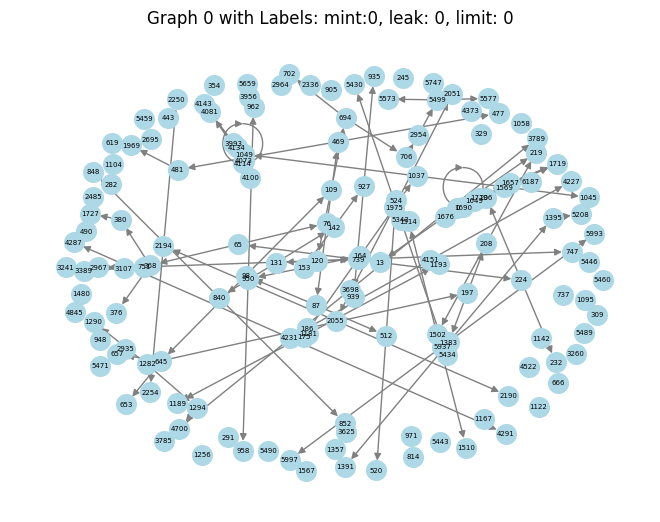

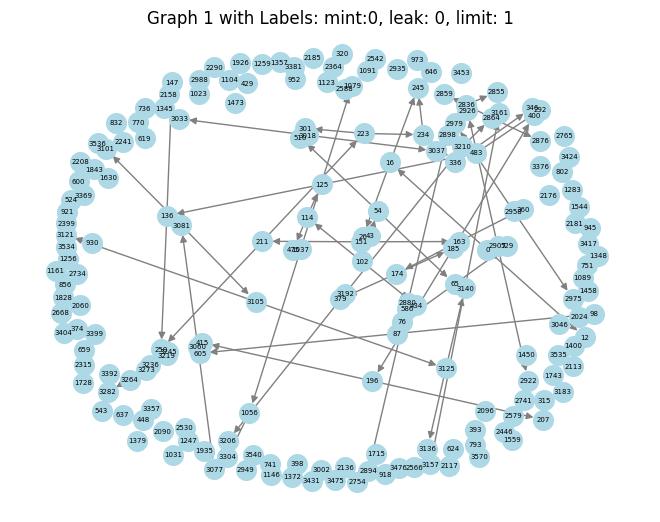

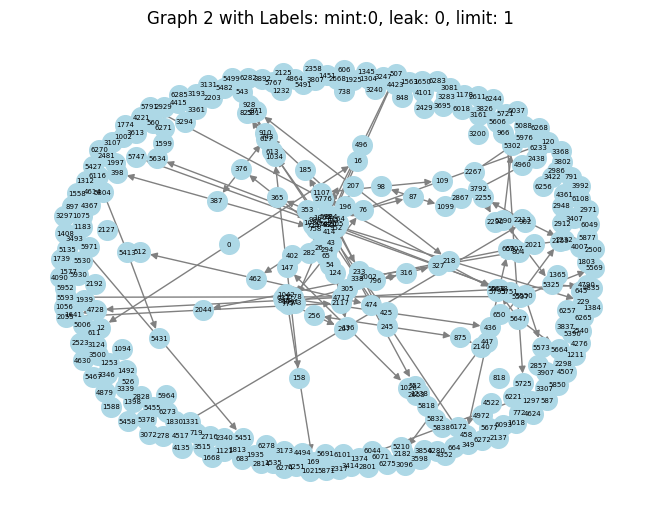

In [96]:
import networkx as nx
import matplotlib.pyplot as plt

for i, (graph, label) in enumerate(zip(graphs, labels)):
    nx.draw(graph, with_labels=True, node_color='lightblue', node_size=200, edge_color='gray', font_size=5)
    plt.title(f"Graph {i} with Labels: mint:{label['mint']}, leak: {label['mint']}, limit: {label['limit']}")
    plt.tight_layout()
    plt.show()
    if i == 2:
        break

## Install required packages.

In [97]:
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"
print(torch.__version__)
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git


2.6.0+cu124
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-08k4aeci
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-08k4aeci
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit ab6037b93077ca936a92b1a5ae876403e30cde0c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [98]:
def extract_graph_features(G):
    return {
        "num_nodes": G.number_of_nodes(),
        "num_edges": G.number_of_edges(),
        "avg_degree": sum(dict(G.degree()).values()) / G.number_of_nodes(),
        "density": nx.density(G),
        "connected_components": nx.number_weakly_connected_components(G),
        "avg_clustering": nx.average_clustering(G.to_undirected())
    }


In [99]:
import torch
from torch_geometric.utils import from_networkx

dataset = []

for graph, label in zip(graphs, labels):
    data = from_networkx(graph)
    label_value = [l for l in label.values()]
    features = extract_graph_features(graph)
    degrees = torch.tensor([d for _, d in graph.degree()], dtype=torch.float).unsqueeze(1)

    # Concatenate node degrees with graph-level features for each node
    graph_features_tensor = torch.tensor(list(features.values()), dtype=torch.float).unsqueeze(0).repeat(data.num_nodes, 1)
    data.x = torch.cat([degrees, graph_features_tensor], dim=1)


    data.y = torch.tensor(label_value, dtype=torch.float).unsqueeze(0)
    # data.x = torch.tensor([d for _, d in graph.degree()]+ list(features.values()), dtype=torch.float).unsqueeze(1)
    # data.x = degrees
    print(data)
    dataset.append(data)

Data(edge_index=[2, 118], num_nodes=155, x=[155, 7], y=[1, 3])
Data(edge_index=[2, 96], num_nodes=194, x=[194, 7], y=[1, 3])
Data(edge_index=[2, 178], num_nodes=339, x=[339, 7], y=[1, 3])
Data(edge_index=[2, 78], num_nodes=113, x=[113, 7], y=[1, 3])
Data(edge_index=[2, 211], num_nodes=303, x=[303, 7], y=[1, 3])
Data(edge_index=[2, 158], num_nodes=377, x=[377, 7], y=[1, 3])
Data(edge_index=[2, 365], num_nodes=683, x=[683, 7], y=[1, 3])
Data(edge_index=[2, 137], num_nodes=215, x=[215, 7], y=[1, 3])
Data(edge_index=[2, 96], num_nodes=192, x=[192, 7], y=[1, 3])
Data(edge_index=[2, 4], num_nodes=584, x=[584, 7], y=[1, 3])
Data(edge_index=[2, 150], num_nodes=520, x=[520, 7], y=[1, 3])
Data(edge_index=[2, 94], num_nodes=151, x=[151, 7], y=[1, 3])
Data(edge_index=[2, 99], num_nodes=197, x=[197, 7], y=[1, 3])
Data(edge_index=[2, 104], num_nodes=169, x=[169, 7], y=[1, 3])
Data(edge_index=[2, 175], num_nodes=294, x=[294, 7], y=[1, 3])
Data(edge_index=[2, 24], num_nodes=561, x=[561, 7], y=[1, 3])


In [100]:
from torch_geometric.data import DataLoader

# Data Loader
loader = DataLoader(dataset, batch_size=4, shuffle=True)

/tmp/ipython-input-100-1246845923.py:4: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  loader = DataLoader(dataset, batch_size=4, shuffle=True)


In [101]:
for batch in loader:
    print(batch)
    print(batch.x.shape, batch.y.shape)
    break

DataBatch(edge_index=[2, 386], num_nodes=2555, x=[2555, 7], y=[4, 3], batch=[2555], ptr=[5])
torch.Size([2555, 7]) torch.Size([4, 3])


In [102]:
import numpy as np
from sklearn.metrics import f1_score

def tune_thresholds(y_true, y_pred_prob, metric='f1'):
    y_true = np.asarray(y_true)          # Fix: convert to NumPy
    y_pred_prob = np.asarray(y_pred_prob)

    best_thresholds = []
    best_scores = []

    for i in range(y_true.shape[1]):
        label_true = y_true[:, i]
        label_probs = y_pred_prob[:, i]  # Fix here too

        thresholds = np.linspace(0.0, 1.0, 101)
        scores = []

        for t in thresholds:
            label_pred = (label_probs >= t).astype(int)
            if metric == 'f1':
                score = f1_score(label_true, label_pred, zero_division=0)
            scores.append(score)

        best_t = thresholds[np.argmax(scores)]
        best_score = np.max(scores)

        best_thresholds.append(best_t)
        best_scores.append(best_score)

        print(f"Label {i}: Best threshold = {best_t:.2f}, Best {metric} = {best_score:.4f}")

    return best_thresholds, best_scores


In [103]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Define the GNN Model
class MultiLabelGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_labels):
        super(MultiLabelGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, num_labels)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        x = torch.sigmoid(self.lin(x))  # Multi-label sigmoid activation
        return x

# Split your dataset
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
test_loader = DataLoader(test_data, batch_size=8, shuffle=False)

# Initialize Model, Loss, Optimizer
# in_channels should be the number of features per node now.
model = MultiLabelGCN(in_channels=7, hidden_channels=64, num_labels=3)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [104]:
# Training Loop
for epoch in range(1, 101):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1, Loss: 7.9105
Epoch 2, Loss: 3.7276
Epoch 3, Loss: 2.7013
Epoch 4, Loss: 2.2034
Epoch 5, Loss: 1.1529
Epoch 6, Loss: 0.9065
Epoch 7, Loss: 0.7577
Epoch 8, Loss: 0.6191
Epoch 9, Loss: 0.5800
Epoch 10, Loss: 0.5934
Epoch 11, Loss: 0.6739
Epoch 12, Loss: 0.7875
Epoch 13, Loss: 0.6980
Epoch 14, Loss: 0.5756
Epoch 15, Loss: 0.6266
Epoch 16, Loss: 0.5265
Epoch 17, Loss: 0.5735
Epoch 18, Loss: 0.6849
Epoch 19, Loss: 0.6116
Epoch 20, Loss: 0.6198
Epoch 21, Loss: 0.6098
Epoch 22, Loss: 0.5798
Epoch 23, Loss: 0.5987
Epoch 24, Loss: 0.5199
Epoch 25, Loss: 0.6745
Epoch 26, Loss: 0.5838
Epoch 27, Loss: 0.5802
Epoch 28, Loss: 0.5404
Epoch 29, Loss: 0.5671
Epoch 30, Loss: 0.5901
Epoch 31, Loss: 0.4943
Epoch 32, Loss: 0.4769
Epoch 33, Loss: 0.5088
Epoch 34, Loss: 0.5182
Epoch 35, Loss: 0.4700
Epoch 36, Loss: 0.5196
Epoch 37, Loss: 0.5318
Epoch 38, Loss: 0.5057
Epoch 39, Loss: 0.5402
Epoch 40, Loss: 0.6337
Epoch 41, Loss: 0.4855
Epoch 42, Loss: 0.5392
Epoch 43, Loss: 0.4657
Epoch 44, Loss: 0.56

In [105]:
# Evaluation Function
def evaluate(loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in loader:
            out = model(batch.x, batch.edge_index, batch.batch)
            best_thresholds, _ = tune_thresholds(batch.y.cpu(), out.cpu()) # Pass out.cpu() to tune_thresholds
            best_thresholds = torch.tensor(best_thresholds, device=out.device) # Convert best_thresholds to a tensor
            pred = (out > best_thresholds).float()
            y_pred.append(pred.cpu())
            y_true.append(batch.y.cpu())
    y_true = torch.vstack(y_true).numpy()
    y_pred = torch.vstack(y_pred).numpy()
    print(classification_report(y_true, y_pred, target_names=['mint', 'leak', 'limit']))

# Run Evaluation
evaluate(test_loader)

Label 0: Best threshold = 0.32, Best f1 = 0.7500
Label 1: Best threshold = 0.13, Best f1 = 0.3333
Label 2: Best threshold = 0.49, Best f1 = 0.8000
Label 0: Best threshold = 0.08, Best f1 = 0.8000
Label 1: Best threshold = 0.20, Best f1 = 0.4000
Label 2: Best threshold = 0.00, Best f1 = 0.6667
              precision    recall  f1-score   support

        mint       0.71      0.83      0.77         6
        leak       0.22      1.00      0.36         2
       limit       0.62      0.83      0.71         6

   micro avg       0.50      0.86      0.63        14
   macro avg       0.52      0.89      0.62        14
weighted avg       0.61      0.86      0.69        14
 samples avg       0.48      0.62      0.52        14



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
